In [15]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
import os


In [16]:
dataset_dir = './data/train'

# Inisialisasi dictionary untuk menyimpan jumlah file setiap kelas
class_file_count = {}

# Loop melalui setiap kelas dalam direktori
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    # Menghitung jumlah file dalam setiap kelas
    file_count = len(os.listdir(class_path))
    
    # Menyimpan jumlah file dalam dictionary
    class_file_count[class_name] = file_count

# Menampilkan jumlah file setiap kelas
for class_name, count in class_file_count.items():
    print(f"Kelas train'{class_name}' memiliki {count} file.")

Kelas train'celana_panjang' memiliki 253 file.
Kelas train'celana_pendek' memiliki 246 file.
Kelas train'kemeja' memiliki 244 file.
Kelas train'sepatu' memiliki 240 file.
Kelas train'skirt' memiliki 242 file.
Kelas train'sweater_and_jacket' memiliki 340 file.
Kelas train't-shirt' memiliki 339 file.


In [17]:
dataset_dir = './data/validation'

# Inisialisasi dictionary untuk menyimpan jumlah file setiap kelas
class_file_count = {}

# Loop melalui setiap kelas dalam direktori
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    # Menghitung jumlah file dalam setiap kelas
    file_count = len(os.listdir(class_path))
    
    # Menyimpan jumlah file dalam dictionary
    class_file_count[class_name] = file_count

# Menampilkan jumlah file setiap kelas
for class_name, count in class_file_count.items():
    print(f"Kelas validasi'{class_name}' memiliki {count} file.")

Kelas validasi'celana_panjang' memiliki 64 file.
Kelas validasi'celana_pendek' memiliki 62 file.
Kelas validasi'kemeja' memiliki 61 file.
Kelas validasi'sepatu' memiliki 60 file.
Kelas validasi'skirt' memiliki 60 file.
Kelas validasi'sweater_and_jacket' memiliki 85 file.
Kelas validasi't-shirt' memiliki 85 file.


In [18]:
#folder_path = 'C:\\capstopne 2\\data\\train\\t-shirt' # Ganti dengan path menuju folder yang berisi gambar

# Mendapatkan daftar file dalam folder
#files = os.listdir(folder_path)

# Iterasi melalui setiap file dalam folder
#for index, file_name in enumerate(files):
    # Ubah nama file sesuai kebutuhan, contoh: gambar1.jpg, gambar2.jpg, dll.
   # new_file_name = f"gambar{index + 1}.jpg"
    
    # Path file lama dan file baru
    #old_path = os.path.join(folder_path, file_name)
    #new_path = os.path.join(folder_path, new_file_name)
    
    # Ubah nama file menggunakan os.rename()
    #os.rename(old_path, new_path)


In [19]:
train_dir = './data/train'
val_dir = './data/validation'

image_width = 150
image_height = 150
batch_size = 32


In [20]:
#class myCallback(tf.keras.callbacks.Callback):
 #   def on_epoch_end(self, epoch, logs={}):
  #      if logs.get('accuracy')>=0.88 and logs.get('val_accuracy') >= 0.80:
   #         print("\nReached 80.0% accuracy so cancelling training!")
    #        self.model.stop_training = True

In [21]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 40,
                                    width_shift_range = 0.25,
                                    height_shift_range = 0.25,
                                    shear_range = 0.2,
                                    horizontal_flip = True,
                                    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_width, image_height),
    batch_size=5,
    class_mode='categorical')

Found 1904 images belonging to 7 classes.
Found 477 images belonging to 7 classes.


In [33]:
# Bangun arsitektur model
#callback=myCallback()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=(image_width, image_height, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    
    tf.keras.layers.Dense(7, activation='softmax')  # Jumlah kelas
])

# Compile model
model.compile(optimizer ='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping= EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


history=model.fit(
    train_generator,
    epochs=100,
    validation_data= validation_generator,
    callbacks=[early_stopping])

Epoch 1/100
60/60 [==============================] - 51s 832ms/step - loss: 1.9055 - accuracy: 0.2148 - val_loss: 1.8753 - val_accuracy: 0.2306
Epoch 2/100
60/60 [==============================] - 50s 838ms/step - loss: 1.7317 - accuracy: 0.2789 - val_loss: 1.7192 - val_accuracy: 0.2851
Epoch 3/100
60/60 [==============================] - 51s 843ms/step - loss: 1.5902 - accuracy: 0.3566 - val_loss: 1.7276 - val_accuracy: 0.3795
Epoch 4/100
60/60 [==============================] - 51s 858ms/step - loss: 1.5175 - accuracy: 0.3876 - val_loss: 1.6492 - val_accuracy: 0.3857
Epoch 5/100
60/60 [==============================] - 50s 825ms/step - loss: 1.4740 - accuracy: 0.4060 - val_loss: 1.6515 - val_accuracy: 0.4319
Epoch 6/100
60/60 [==============================] - 50s 829ms/step - loss: 1.4283 - accuracy: 0.4223 - val_loss: 1.5441 - val_accuracy: 0.4612
Epoch 7/100
60/60 [==============================] - 50s 826ms/step - loss: 1.3765 - accuracy: 0.4501 - val_loss: 1.5973 - val_accuracy:

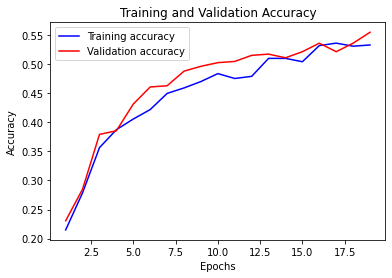

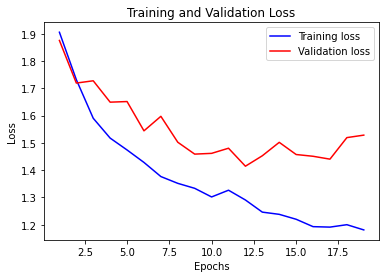

In [34]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plot grafik
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

# Plot train & validation loss
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
model.save('model_coba.h5')

In [26]:
class_labels = list(train_generator.class_indices.keys())
print(class_labels)

['celana_panjang', 'celana_pendek', 'kemeja', 'sepatu', 'skirt', 'sweater_and_jacket', 't-shirt']
